In [252]:
import os
import pickle
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import glob 
import numpy as np
import matplotlib.pyplot as plt
import requests
import xarray as xr
from datetime import datetime, timedelta, time as dt_time
import h5py
import datetime
import traceback
from urllib.parse import urljoin
from concurrent.futures import ThreadPoolExecutor, as_completed
import pytz
import time
import tropycal.tracks as tracks
pd.set_option('display.max_rows', 500)

afternoon precipitation event identification

- GPM resolution: 0.1 degree

- morning (0600-1300 LST), afternoon (1400-2000 LST), and evening (2100-2400 LST)

- Afternoon precipitation events (APEs) are identified as daily samples that meet the following criteria: 1) daily precipitation peaks during the afternoon hours defined above; and 2) the afternoon precipitation is at least twice as large as the morning precipitation, and also greater than the evening precipitation. 3) at least one half-hourly observation in the afternoon is > 0.5 mm measured in the half-hourly observation (= 1 mm/hr) 4) precipitation is not a result of a mesoscale convective system

- check for satisfaction of afternoon precipitation event at every gridpoint
- if an afternoon precipitation event is identified, record the date and the grid points satisfying it
- later, will cross reference gridpoint with soil moisture and ctp/hi-low calculations to further identify as dry-coupling or wet-coupling cases 


In [492]:
#reading in HDF5 files

base_folder_path = '/data/rong3/annie/gpm'

start_year = 2005

end_year = 2005

# Collect all files from the specified years
all_gpm_files = []

for year in range(start_year, end_year + 1):
    
    folder_path = os.path.join(base_folder_path, str(year))
    
    gpm_files = sorted(glob.glob(os.path.join(folder_path, '*.HDF5')))
    
    all_gpm_files.extend(gpm_files)

    
# all_gpm_files = all_gpm_files[1000:2000]   

# Number of files collected
print(f"Total files collected: {len(all_gpm_files)}")

Total files collected: 7344


In [493]:
#parallel processed

lon_lat_indices = []

base_date = datetime.datetime(1980, 1, 6, 0, 0, 0)

lat_start = 30.05

lat_end = 39.05

lon_start = -105.05

lon_end = -95.05

def convert_to_cst(seconds_since_base):
    
    if isinstance(seconds_since_base, (np.int32, np.int64)):
        
        seconds_since_base = int(seconds_since_base)
    
    time_delta = timedelta(seconds=seconds_since_base)
    
    # Calculate UTC time
    utc_time = base_date + time_delta
    
    # Convert UTC time to CST (subtract 6 hours for CST)
    cst_time = utc_time - timedelta(hours=6)
    
    # Remove timezone information to make it naive
    naive_cst_time = cst_time.replace(tzinfo=None)

    return naive_cst_time

def process_file(file):
    
    try: 
        
        if os.path.isfile(file) and os.path.getsize(file) > 0:

            with h5py.File(file, 'r', locking=False) as f:

                # Geographical filtering

                lon = f['Grid/lon'][:]

                lat = f['Grid/lat'][:]

                lon_mask = (lon >= lon_start) & (lon <= lon_end)

                lat_mask = (lat >= lat_start) & (lat <= lat_end)

                lon_indices = np.where(lon_mask)[0]

                lat_indices = np.where(lat_mask)[0]

                # Time conversion
                time = f['Grid/time'][:][0]

                lst = convert_to_cst(time)
                print(lst)

                # Precipitation filtering by geography
                precip = xr.DataArray(f['Grid/precipitation'][:][0], dims=['lon', 'lat'])

                psgp = precip.isel(lon=lon_indices, lat=lat_indices)

                return lst, psgp 

        else:

            print(f"Not a file: {file}")

            return None, None
        
    except (KeyError, OSError, IOError) as e:
        # Catch specific file-related exceptions
        
        print(f"Error while processing {file}: {e}")
        
        traceback.print_exc()  # Optional: print detailed stack trace
        
        return None, None

    except Exception as e:
        # Catch all other exceptions
        
        print(f"Unexpected error while processing {file}: {e}")
        
        traceback.print_exc()  # Optional: print detailed stack trace
        
        return None, None
    

results_dict = {}

# Process each file and store results in the dictionary
for file in all_gpm_files:
    
    lst, domain_precip = process_file(file)
    
    if lst is not None:
        
        results_dict[lst] = domain_precip

2005-04-30 18:00:00
2005-04-30 18:30:00
2005-04-30 19:00:00
2005-04-30 19:30:00
2005-04-30 20:00:00
2005-04-30 20:30:00
2005-04-30 21:00:00
2005-04-30 21:30:00
2005-04-30 22:00:00
2005-04-30 22:30:00
2005-04-30 23:00:00
2005-04-30 23:30:00
2005-05-01 00:00:00
2005-05-01 00:30:00
2005-05-01 01:00:00
2005-05-01 01:30:00
2005-05-01 02:00:00
2005-05-01 02:30:00
2005-05-01 03:00:00
2005-05-01 03:30:00
2005-05-01 04:00:00
2005-05-01 04:30:00
2005-05-01 05:00:00
2005-05-01 05:30:00
2005-05-01 06:00:00
2005-05-01 06:30:00
2005-05-01 07:00:00
2005-05-01 07:30:00
2005-05-01 08:00:00
2005-05-01 08:30:00
2005-05-01 09:00:00
2005-05-01 09:30:00
2005-05-01 10:00:00
2005-05-01 10:30:00
2005-05-01 11:00:00
2005-05-01 11:30:00
2005-05-01 12:00:00
2005-05-01 12:30:00
2005-05-01 13:00:00
2005-05-01 13:30:00
2005-05-01 14:00:00
2005-05-01 14:30:00
2005-05-01 15:00:00
2005-05-01 15:30:00
2005-05-01 16:00:00
2005-05-01 16:30:00
2005-05-01 17:00:00
2005-05-01 17:30:00
2005-05-01 18:00:00
2005-05-01 18:30:00


2005-05-09 07:00:00
2005-05-09 07:30:00
2005-05-09 08:00:00
2005-05-09 08:30:00
2005-05-09 09:00:00
2005-05-09 09:30:00
2005-05-09 10:00:00
2005-05-09 10:30:00
2005-05-09 11:00:00
2005-05-09 11:30:00
2005-05-09 12:00:00
2005-05-09 12:30:00
2005-05-09 13:00:00
2005-05-09 13:30:00
2005-05-09 14:00:00
2005-05-09 14:30:00
2005-05-09 15:00:00
2005-05-09 15:30:00
2005-05-09 16:00:00
2005-05-09 16:30:00
2005-05-09 17:00:00
2005-05-09 17:30:00
2005-05-09 18:00:00
2005-05-09 18:30:00
2005-05-09 19:00:00
2005-05-09 19:30:00
2005-05-09 20:00:00
2005-05-09 20:30:00
2005-05-09 21:00:00
2005-05-09 21:30:00
2005-05-09 22:00:00
2005-05-09 22:30:00
2005-05-09 23:00:00
2005-05-09 23:30:00
2005-05-10 00:00:00
2005-05-10 00:30:00
2005-05-10 01:00:00
2005-05-10 01:30:00
2005-05-10 02:00:00
2005-05-10 02:30:00
2005-05-10 03:00:00
2005-05-10 03:30:00
2005-05-10 04:00:00
2005-05-10 04:30:00
2005-05-10 05:00:00
2005-05-10 05:30:00
2005-05-10 06:00:00
2005-05-10 06:30:00
2005-05-10 07:00:00
2005-05-10 07:30:00


2005-05-17 20:00:00
2005-05-17 20:30:00
2005-05-17 21:00:00
2005-05-17 21:30:00
2005-05-17 22:00:00
2005-05-17 22:30:00
2005-05-17 23:00:00
2005-05-17 23:30:00
2005-05-18 00:00:00
2005-05-18 00:30:00
2005-05-18 01:00:00
2005-05-18 01:30:00
2005-05-18 02:00:00
2005-05-18 02:30:00
2005-05-18 03:00:00
2005-05-18 03:30:00
2005-05-18 04:00:00
2005-05-18 04:30:00
2005-05-18 05:00:00
2005-05-18 05:30:00
2005-05-18 06:00:00
2005-05-18 06:30:00
2005-05-18 07:00:00
2005-05-18 07:30:00
2005-05-18 08:00:00
2005-05-18 08:30:00
2005-05-18 09:00:00
2005-05-18 09:30:00
2005-05-18 10:00:00
2005-05-18 10:30:00
2005-05-18 11:00:00
2005-05-18 11:30:00
2005-05-18 12:00:00
2005-05-18 12:30:00
2005-05-18 13:00:00
2005-05-18 13:30:00
2005-05-18 14:00:00
2005-05-18 14:30:00
2005-05-18 15:00:00
2005-05-18 15:30:00
2005-05-18 16:00:00
2005-05-18 16:30:00
2005-05-18 17:00:00
2005-05-18 17:30:00
2005-05-18 18:00:00
2005-05-18 18:30:00
2005-05-18 19:00:00
2005-05-18 19:30:00
2005-05-18 20:00:00
2005-05-18 20:30:00


2005-05-26 09:30:00
2005-05-26 10:00:00
2005-05-26 10:30:00
2005-05-26 11:00:00
2005-05-26 11:30:00
2005-05-26 12:00:00
2005-05-26 12:30:00
2005-05-26 13:00:00
2005-05-26 13:30:00
2005-05-26 14:00:00
2005-05-26 14:30:00
2005-05-26 15:00:00
2005-05-26 15:30:00
2005-05-26 16:00:00
2005-05-26 16:30:00
2005-05-26 17:00:00
2005-05-26 17:30:00
2005-05-26 18:00:00
2005-05-26 18:30:00
2005-05-26 19:00:00
2005-05-26 19:30:00
2005-05-26 20:00:00
2005-05-26 20:30:00
2005-05-26 21:00:00
2005-05-26 21:30:00
2005-05-26 22:00:00
2005-05-26 22:30:00
2005-05-26 23:00:00
2005-05-26 23:30:00
2005-05-27 00:00:00
2005-05-27 00:30:00
2005-05-27 01:00:00
2005-05-27 01:30:00
2005-05-27 02:00:00
2005-05-27 02:30:00
2005-05-27 03:00:00
2005-05-27 03:30:00
2005-05-27 04:00:00
2005-05-27 04:30:00
2005-05-27 05:00:00
2005-05-27 05:30:00
2005-05-27 06:00:00
2005-05-27 06:30:00
2005-05-27 07:00:00
2005-05-27 07:30:00
2005-05-27 08:00:00
2005-05-27 08:30:00
2005-05-27 09:00:00
2005-05-27 09:30:00
2005-05-27 10:00:00


2005-06-03 22:30:00
2005-06-03 23:00:00
2005-06-03 23:30:00
2005-06-04 00:00:00
2005-06-04 00:30:00
2005-06-04 01:00:00
2005-06-04 01:30:00
2005-06-04 02:00:00
2005-06-04 02:30:00
2005-06-04 03:00:00
2005-06-04 03:30:00
2005-06-04 04:00:00
2005-06-04 04:30:00
2005-06-04 05:00:00
2005-06-04 05:30:00
2005-06-04 06:00:00
2005-06-04 06:30:00
2005-06-04 07:00:00
2005-06-04 07:30:00
2005-06-04 08:00:00
2005-06-04 08:30:00
2005-06-04 09:00:00
2005-06-04 09:30:00
2005-06-04 10:00:00
2005-06-04 10:30:00
2005-06-04 11:00:00
2005-06-04 11:30:00
2005-06-04 12:00:00
2005-06-04 12:30:00
2005-06-04 13:00:00
2005-06-04 13:30:00
2005-06-04 14:00:00
2005-06-04 14:30:00
2005-06-04 15:00:00
2005-06-04 15:30:00
2005-06-04 16:00:00
Not a file: /data/rong3/annie/gpm/2005/3B-HHR.MS.MRG.3IMERG.20050604-S223000-E225959.1350.V07B.HDF5
2005-06-04 17:00:00
2005-06-04 17:30:00
2005-06-04 18:00:00
2005-06-04 18:30:00
2005-06-04 19:00:00
2005-06-04 19:30:00
2005-06-04 20:00:00
2005-06-04 20:30:00
2005-06-04 21:00:00


2005-06-12 11:00:00
2005-06-12 11:30:00
2005-06-12 12:00:00
2005-06-12 12:30:00
2005-06-12 13:00:00
2005-06-12 13:30:00
2005-06-12 14:00:00
2005-06-12 14:30:00
2005-06-12 15:00:00
2005-06-12 15:30:00
2005-06-12 16:00:00
2005-06-12 16:30:00
2005-06-12 17:00:00
2005-06-12 17:30:00
2005-06-12 18:00:00
2005-06-12 18:30:00
2005-06-12 19:00:00
2005-06-12 19:30:00
2005-06-12 20:00:00
2005-06-12 20:30:00
2005-06-12 21:00:00
2005-06-12 21:30:00
2005-06-12 22:00:00
2005-06-12 22:30:00
2005-06-12 23:00:00
2005-06-12 23:30:00
2005-06-13 00:00:00
2005-06-13 00:30:00
2005-06-13 01:00:00
2005-06-13 01:30:00
2005-06-13 02:00:00
2005-06-13 02:30:00
2005-06-13 03:00:00
2005-06-13 03:30:00
2005-06-13 04:00:00
2005-06-13 04:30:00
2005-06-13 05:00:00
2005-06-13 05:30:00
2005-06-13 06:00:00
2005-06-13 06:30:00
2005-06-13 07:00:00
2005-06-13 07:30:00
2005-06-13 08:00:00
2005-06-13 08:30:00
2005-06-13 09:00:00
2005-06-13 09:30:00
2005-06-13 10:00:00
2005-06-13 10:30:00
2005-06-13 11:00:00
2005-06-13 11:30:00


2005-06-21 01:30:00
2005-06-21 02:00:00
2005-06-21 02:30:00
2005-06-21 03:00:00
2005-06-21 03:30:00
2005-06-21 04:00:00
2005-06-21 04:30:00
2005-06-21 05:00:00
2005-06-21 05:30:00
2005-06-21 06:00:00
2005-06-21 06:30:00
2005-06-21 07:00:00
2005-06-21 07:30:00
2005-06-21 08:00:00
2005-06-21 08:30:00
2005-06-21 09:00:00
2005-06-21 09:30:00
2005-06-21 10:00:00
2005-06-21 10:30:00
2005-06-21 11:00:00
2005-06-21 11:30:00
2005-06-21 12:00:00
2005-06-21 12:30:00
2005-06-21 13:00:00
2005-06-21 13:30:00
2005-06-21 14:00:00
2005-06-21 14:30:00
2005-06-21 15:00:00
2005-06-21 15:30:00
2005-06-21 16:00:00
2005-06-21 16:30:00
2005-06-21 17:00:00
2005-06-21 17:30:00
2005-06-21 18:00:00
2005-06-21 18:30:00
2005-06-21 19:00:00
2005-06-21 19:30:00
2005-06-21 20:00:00
2005-06-21 20:30:00
2005-06-21 21:00:00
2005-06-21 21:30:00
2005-06-21 22:00:00
2005-06-21 22:30:00
2005-06-21 23:00:00
2005-06-21 23:30:00
2005-06-22 00:00:00
2005-06-22 00:30:00
2005-06-22 01:00:00
2005-06-22 01:30:00
2005-06-22 02:00:00


2005-06-29 15:30:00
2005-06-29 16:00:00
2005-06-29 16:30:00
2005-06-29 17:00:00
2005-06-29 17:30:00
2005-06-29 18:00:00
2005-06-29 18:30:00
2005-06-29 19:00:00
2005-06-29 19:30:00
2005-06-29 20:00:00
2005-06-29 20:30:00
2005-06-29 21:00:00
2005-06-29 21:30:00
2005-06-29 22:00:00
2005-06-29 22:30:00
2005-06-29 23:00:00
2005-06-29 23:30:00
2005-06-30 00:00:00
2005-06-30 00:30:00
2005-06-30 01:00:00
2005-06-30 01:30:00
2005-06-30 02:00:00
2005-06-30 02:30:00
2005-06-30 03:00:00
2005-06-30 03:30:00
2005-06-30 04:00:00
2005-06-30 04:30:00
2005-06-30 05:00:00
2005-06-30 05:30:00
2005-06-30 06:00:00
2005-06-30 06:30:00
2005-06-30 07:00:00
2005-06-30 07:30:00
2005-06-30 08:00:00
2005-06-30 08:30:00
2005-06-30 09:00:00
2005-06-30 09:30:00
2005-06-30 10:00:00
2005-06-30 10:30:00
2005-06-30 11:00:00
2005-06-30 11:30:00
2005-06-30 12:00:00
2005-06-30 12:30:00
2005-06-30 13:00:00
2005-06-30 13:30:00
2005-06-30 14:00:00
2005-06-30 14:30:00
2005-06-30 15:00:00
2005-06-30 15:30:00
2005-06-30 16:00:00


2005-07-08 03:30:00
2005-07-08 04:00:00
2005-07-08 04:30:00
2005-07-08 05:00:00
2005-07-08 05:30:00
2005-07-08 06:00:00
2005-07-08 06:30:00
2005-07-08 07:00:00
2005-07-08 07:30:00
2005-07-08 08:00:00
2005-07-08 08:30:00
2005-07-08 09:00:00
2005-07-08 09:30:00
2005-07-08 10:00:00
2005-07-08 10:30:00
2005-07-08 11:00:00
2005-07-08 11:30:00
2005-07-08 12:00:00
2005-07-08 12:30:00
2005-07-08 13:00:00
2005-07-08 13:30:00
2005-07-08 14:00:00
2005-07-08 14:30:00
2005-07-08 15:00:00
2005-07-08 15:30:00
2005-07-08 16:00:00
2005-07-08 16:30:00
2005-07-08 17:00:00
2005-07-08 17:30:00
2005-07-08 18:00:00
2005-07-08 18:30:00
2005-07-08 19:00:00
2005-07-08 19:30:00
2005-07-08 20:00:00
2005-07-08 20:30:00
2005-07-08 21:00:00
2005-07-08 21:30:00
2005-07-08 22:00:00
2005-07-08 22:30:00
2005-07-08 23:00:00
2005-07-08 23:30:00
2005-07-09 00:00:00
2005-07-09 00:30:00
2005-07-09 01:00:00
2005-07-09 01:30:00
2005-07-09 02:00:00
2005-07-09 02:30:00
2005-07-09 03:00:00
2005-07-09 03:30:00
2005-07-09 04:00:00


2005-07-16 16:30:00
2005-07-16 17:00:00
2005-07-16 17:30:00
2005-07-16 18:00:00
2005-07-16 18:30:00
2005-07-16 19:00:00
2005-07-16 19:30:00
2005-07-16 20:00:00
2005-07-16 20:30:00
2005-07-16 21:00:00
2005-07-16 21:30:00
2005-07-16 22:00:00
2005-07-16 22:30:00
2005-07-16 23:00:00
2005-07-16 23:30:00
2005-07-17 00:00:00
2005-07-17 00:30:00
2005-07-17 01:00:00
2005-07-17 01:30:00
2005-07-17 02:00:00
2005-07-17 02:30:00
2005-07-17 03:00:00
2005-07-17 03:30:00
2005-07-17 04:00:00
2005-07-17 04:30:00
2005-07-17 05:00:00
2005-07-17 05:30:00
2005-07-17 06:00:00
2005-07-17 06:30:00
2005-07-17 07:00:00
2005-07-17 07:30:00
2005-07-17 08:00:00
2005-07-17 08:30:00
2005-07-17 09:00:00
2005-07-17 09:30:00
2005-07-17 10:00:00
2005-07-17 10:30:00
2005-07-17 11:00:00
2005-07-17 11:30:00
2005-07-17 12:00:00
2005-07-17 12:30:00
2005-07-17 13:00:00
2005-07-17 13:30:00
2005-07-17 14:00:00
2005-07-17 14:30:00
2005-07-17 15:00:00
2005-07-17 15:30:00
2005-07-17 16:00:00
2005-07-17 16:30:00
2005-07-17 17:00:00


2005-07-25 06:00:00
2005-07-25 06:30:00
2005-07-25 07:00:00
2005-07-25 07:30:00
2005-07-25 08:00:00
2005-07-25 08:30:00
2005-07-25 09:00:00
2005-07-25 09:30:00
2005-07-25 10:00:00
2005-07-25 10:30:00
2005-07-25 11:00:00
2005-07-25 11:30:00
2005-07-25 12:00:00
2005-07-25 12:30:00
2005-07-25 13:00:00
2005-07-25 13:30:00
2005-07-25 14:00:00
2005-07-25 14:30:00
2005-07-25 15:00:00
2005-07-25 15:30:00
2005-07-25 16:00:00
2005-07-25 16:30:00
2005-07-25 17:00:00
2005-07-25 17:30:00
2005-07-25 18:00:00
2005-07-25 18:30:00
2005-07-25 19:00:00
2005-07-25 19:30:00
2005-07-25 20:00:00
2005-07-25 20:30:00
2005-07-25 21:00:00
2005-07-25 21:30:00
2005-07-25 22:00:00
2005-07-25 22:30:00
2005-07-25 23:00:00
2005-07-25 23:30:00
2005-07-26 00:00:00
2005-07-26 00:30:00
2005-07-26 01:00:00
2005-07-26 01:30:00
2005-07-26 02:00:00
2005-07-26 02:30:00
2005-07-26 03:00:00
2005-07-26 03:30:00
2005-07-26 04:00:00
2005-07-26 04:30:00
2005-07-26 05:00:00
2005-07-26 05:30:00
2005-07-26 06:00:00
2005-07-26 06:30:00


2005-08-02 19:00:00
2005-08-02 19:30:00
2005-08-02 20:00:00
2005-08-02 20:30:00
2005-08-02 21:00:00
2005-08-02 21:30:00
2005-08-02 22:00:00
2005-08-02 22:30:00
2005-08-02 23:00:00
2005-08-02 23:30:00
2005-08-03 00:00:00
2005-08-03 00:30:00
2005-08-03 01:00:00
2005-08-03 01:30:00
2005-08-03 02:00:00
2005-08-03 02:30:00
2005-08-03 03:00:00
2005-08-03 03:30:00
2005-08-03 04:00:00
2005-08-03 04:30:00
2005-08-03 05:00:00
2005-08-03 05:30:00
2005-08-03 06:00:00
2005-08-03 06:30:00
2005-08-03 07:00:00
2005-08-03 07:30:00
2005-08-03 08:00:00
2005-08-03 08:30:00
2005-08-03 09:00:00
2005-08-03 09:30:00
2005-08-03 10:00:00
2005-08-03 10:30:00
2005-08-03 11:00:00
2005-08-03 11:30:00
2005-08-03 12:00:00
2005-08-03 12:30:00
2005-08-03 13:00:00
2005-08-03 13:30:00
2005-08-03 14:00:00
2005-08-03 14:30:00
2005-08-03 15:00:00
2005-08-03 15:30:00
2005-08-03 16:00:00
2005-08-03 16:30:00
2005-08-03 17:00:00
2005-08-03 17:30:00
2005-08-03 18:00:00
2005-08-03 18:30:00
2005-08-03 19:00:00
2005-08-03 19:30:00


2005-08-11 09:00:00
2005-08-11 09:30:00
2005-08-11 10:00:00
2005-08-11 10:30:00
2005-08-11 11:00:00
2005-08-11 11:30:00
2005-08-11 12:00:00
2005-08-11 12:30:00
2005-08-11 13:00:00
2005-08-11 13:30:00
2005-08-11 14:00:00
2005-08-11 14:30:00
2005-08-11 15:00:00
2005-08-11 15:30:00
2005-08-11 16:00:00
2005-08-11 16:30:00
2005-08-11 17:00:00
2005-08-11 17:30:00
2005-08-11 18:00:00
2005-08-11 18:30:00
2005-08-11 19:00:00
2005-08-11 19:30:00
2005-08-11 20:00:00
2005-08-11 20:30:00
2005-08-11 21:00:00
2005-08-11 21:30:00
2005-08-11 22:00:00
2005-08-11 22:30:00
2005-08-11 23:00:00
2005-08-11 23:30:00
2005-08-12 00:00:00
2005-08-12 00:30:00
2005-08-12 01:00:00
2005-08-12 01:30:00
2005-08-12 02:00:00
2005-08-12 02:30:00
2005-08-12 03:00:00
2005-08-12 03:30:00
2005-08-12 04:00:00
2005-08-12 04:30:00
2005-08-12 05:00:00
2005-08-12 05:30:00
2005-08-12 06:00:00
2005-08-12 06:30:00
2005-08-12 07:00:00
2005-08-12 07:30:00
2005-08-12 08:00:00
2005-08-12 08:30:00
2005-08-12 09:00:00
2005-08-12 09:30:00


2005-08-19 22:00:00
2005-08-19 22:30:00
2005-08-19 23:00:00
2005-08-19 23:30:00
2005-08-20 00:00:00
2005-08-20 00:30:00
2005-08-20 01:00:00
2005-08-20 01:30:00
2005-08-20 02:00:00
2005-08-20 02:30:00
2005-08-20 03:00:00
2005-08-20 03:30:00
2005-08-20 04:00:00
2005-08-20 04:30:00
2005-08-20 05:00:00
2005-08-20 05:30:00
2005-08-20 06:00:00
2005-08-20 06:30:00
2005-08-20 07:00:00
2005-08-20 07:30:00
2005-08-20 08:00:00
2005-08-20 08:30:00
2005-08-20 09:00:00
2005-08-20 09:30:00
2005-08-20 10:00:00
2005-08-20 10:30:00
2005-08-20 11:00:00
2005-08-20 11:30:00
2005-08-20 12:00:00
2005-08-20 12:30:00
2005-08-20 13:00:00
2005-08-20 13:30:00
2005-08-20 14:00:00
2005-08-20 14:30:00
2005-08-20 15:00:00
2005-08-20 15:30:00
2005-08-20 16:00:00
2005-08-20 16:30:00
2005-08-20 17:00:00
2005-08-20 17:30:00
2005-08-20 18:00:00
2005-08-20 18:30:00
2005-08-20 19:00:00
2005-08-20 19:30:00
2005-08-20 20:00:00
2005-08-20 20:30:00
2005-08-20 21:00:00
2005-08-20 21:30:00
2005-08-20 22:00:00
2005-08-20 22:30:00


2005-08-28 11:30:00
2005-08-28 12:00:00
2005-08-28 12:30:00
2005-08-28 13:00:00
2005-08-28 13:30:00
2005-08-28 14:00:00
2005-08-28 14:30:00
2005-08-28 15:00:00
2005-08-28 15:30:00
2005-08-28 16:00:00
2005-08-28 16:30:00
2005-08-28 17:00:00
2005-08-28 17:30:00
2005-08-28 18:00:00
2005-08-28 18:30:00
2005-08-28 19:00:00
2005-08-28 19:30:00
2005-08-28 20:00:00
2005-08-28 20:30:00
2005-08-28 21:00:00
2005-08-28 21:30:00
2005-08-28 22:00:00
2005-08-28 22:30:00
2005-08-28 23:00:00
2005-08-28 23:30:00
2005-08-29 00:00:00
2005-08-29 00:30:00
2005-08-29 01:00:00
2005-08-29 01:30:00
2005-08-29 02:00:00
2005-08-29 02:30:00
2005-08-29 03:00:00
2005-08-29 03:30:00
2005-08-29 04:00:00
2005-08-29 04:30:00
2005-08-29 05:00:00
2005-08-29 05:30:00
2005-08-29 06:00:00
2005-08-29 06:30:00
2005-08-29 07:00:00
2005-08-29 07:30:00
2005-08-29 08:00:00
2005-08-29 08:30:00
2005-08-29 09:00:00
2005-08-29 09:30:00
2005-08-29 10:00:00
2005-08-29 10:30:00
2005-08-29 11:00:00
2005-08-29 11:30:00
2005-08-29 12:00:00


2005-09-06 01:30:00
2005-09-06 02:00:00
2005-09-06 02:30:00
2005-09-06 03:00:00
2005-09-06 03:30:00
2005-09-06 04:00:00
2005-09-06 04:30:00
2005-09-06 05:00:00
2005-09-06 05:30:00
2005-09-06 06:00:00
2005-09-06 06:30:00
2005-09-06 07:00:00
2005-09-06 07:30:00
2005-09-06 08:00:00
2005-09-06 08:30:00
2005-09-06 09:00:00
2005-09-06 09:30:00
2005-09-06 10:00:00
2005-09-06 10:30:00
2005-09-06 11:00:00
2005-09-06 11:30:00
2005-09-06 12:00:00
2005-09-06 12:30:00
2005-09-06 13:00:00
2005-09-06 13:30:00
2005-09-06 14:00:00
2005-09-06 14:30:00
2005-09-06 15:00:00
2005-09-06 15:30:00
2005-09-06 16:00:00
2005-09-06 16:30:00
2005-09-06 17:00:00
2005-09-06 17:30:00
2005-09-06 18:00:00
2005-09-06 18:30:00
2005-09-06 19:00:00
2005-09-06 19:30:00
2005-09-06 20:00:00
2005-09-06 20:30:00
2005-09-06 21:00:00
2005-09-06 21:30:00
2005-09-06 22:00:00
2005-09-06 22:30:00
2005-09-06 23:00:00
2005-09-06 23:30:00
2005-09-07 00:00:00
2005-09-07 00:30:00
2005-09-07 01:00:00
2005-09-07 01:30:00
2005-09-07 02:00:00


2005-09-14 15:00:00
2005-09-14 15:30:00
2005-09-14 16:00:00
2005-09-14 16:30:00
2005-09-14 17:00:00
2005-09-14 17:30:00
2005-09-14 18:00:00
2005-09-14 18:30:00
2005-09-14 19:00:00
2005-09-14 19:30:00
2005-09-14 20:00:00
2005-09-14 20:30:00
2005-09-14 21:00:00
2005-09-14 21:30:00
2005-09-14 22:00:00
2005-09-14 22:30:00
2005-09-14 23:00:00
2005-09-14 23:30:00
2005-09-15 00:00:00
2005-09-15 00:30:00
2005-09-15 01:00:00
2005-09-15 01:30:00
2005-09-15 02:00:00
2005-09-15 02:30:00
2005-09-15 03:00:00
2005-09-15 03:30:00
2005-09-15 04:00:00
2005-09-15 04:30:00
2005-09-15 05:00:00
2005-09-15 05:30:00
2005-09-15 06:00:00
2005-09-15 06:30:00
2005-09-15 07:00:00
2005-09-15 07:30:00
2005-09-15 08:00:00
2005-09-15 08:30:00
2005-09-15 09:00:00
2005-09-15 09:30:00
2005-09-15 10:00:00
2005-09-15 10:30:00
2005-09-15 11:00:00
2005-09-15 11:30:00
2005-09-15 12:00:00
2005-09-15 12:30:00
2005-09-15 13:00:00
2005-09-15 13:30:00
2005-09-15 14:00:00
2005-09-15 14:30:00
2005-09-15 15:00:00
2005-09-15 15:30:00


2005-09-23 04:00:00
2005-09-23 04:30:00
2005-09-23 05:00:00
2005-09-23 05:30:00
2005-09-23 06:00:00
2005-09-23 06:30:00
2005-09-23 07:00:00
2005-09-23 07:30:00
2005-09-23 08:00:00
2005-09-23 08:30:00
2005-09-23 09:00:00
2005-09-23 09:30:00
2005-09-23 10:00:00
2005-09-23 10:30:00
2005-09-23 11:00:00
2005-09-23 11:30:00
2005-09-23 12:00:00
2005-09-23 12:30:00
2005-09-23 13:00:00
2005-09-23 13:30:00
2005-09-23 14:00:00
2005-09-23 14:30:00
2005-09-23 15:00:00
2005-09-23 15:30:00
2005-09-23 16:00:00
2005-09-23 16:30:00
2005-09-23 17:00:00
2005-09-23 17:30:00
2005-09-23 18:00:00
2005-09-23 18:30:00
2005-09-23 19:00:00
2005-09-23 19:30:00
2005-09-23 20:00:00
2005-09-23 20:30:00
2005-09-23 21:00:00
2005-09-23 21:30:00
2005-09-23 22:00:00
2005-09-23 22:30:00
2005-09-23 23:00:00
2005-09-23 23:30:00
2005-09-24 00:00:00
2005-09-24 00:30:00
2005-09-24 01:00:00
2005-09-24 01:30:00
2005-09-24 02:00:00
2005-09-24 02:30:00
2005-09-24 03:00:00
2005-09-24 03:30:00
2005-09-24 04:00:00
2005-09-24 04:30:00


In [678]:
def classify_ape(precip_dict):
    
    """
    Classify each day as having Afternoon Precipitation Events (APEs) or not,
    and retain information for the grid point with the highest afternoon precipitation sum
    that satisfies APE criteria, excluding mesoscale convective systems (MCS).

    Parameters:
        precip_dict (dict): Dictionary where keys are datetime objects (half-hour intervals) 
                            and values are 2D arrays of precipitation (100, 91) in mm/hr.
                            
    Returns:
        results (dict): A dictionary where keys are unique dates and values are:
                        - 'APE': True if at least one grid point is classified as an APE, otherwise False.
                        - 'precip_info': List of dicts containing morning, afternoon, and evening precip 
                          for the grid point with the highest afternoon precip sum.
                        - If no APE grid points, 'precip_info' is empty.
    """
    results = {}
    
    # Create time masks
    nocturnal_times = {dt_time(h, m) for h in range(0, 6) for m in (0, 30)}
    
    morning_times = {dt_time(h, m) for h in range(6, 14) for m in (0, 30)}
    
    afternoon_times = {dt_time(h, m) for h in range(14, 21) for m in (0, 30)}
    
    evening_times = {dt_time(h, m) for h in range(21, 24) for m in (0, 30)}
    
    # Example: Map your time steps to datetime.time objects
    time_steps = [dt_time(h, m) for h in range(0, 24) for m in (0, 30)]  # All possible half-hourly times
    
    # Group precipitation data by date and time of day
    
    daily_precip = {}
    
    for dt, precip in precip_dict.items():
        
        precip_total_mm = precip * 0.5
        
        date = dt.date()
        
        t = dt.time()
        
        if date not in daily_precip:
            
            daily_precip[date] = {'nocturnal': [], 'morning': [], 'afternoon': [], 'evening': []}
        
        if t in nocturnal_times: 
            
            daily_precip[date]['nocturnal'].append(precip_total_mm)
        
        elif t in morning_times:
            
            daily_precip[date]['morning'].append(precip_total_mm)
        
        elif t in afternoon_times:
            
            daily_precip[date]['afternoon'].append(precip_total_mm)
        
        elif t in evening_times:
            
            daily_precip[date]['evening'].append(precip_total_mm)

    # Analyze daily precipitation
    
    # times -> dictionary 
    # times['morning'] (etc) -> list of arrays
    # times['morning'][0] -> array of size (100,91) across domain of precipitation at first morning half-hour
     
    for date, times in daily_precip.items():
        
        # creates an array of zeros if any of times[''] are empty
        # sums elementwise across arrays
        
        morning_sum = np.sum(times['morning'], axis=0) if times['morning'] else np.zeros((100, 91))
        
        afternoon_sum = np.sum(times['afternoon'], axis=0) if times['afternoon'] else np.zeros((100, 91))
        
        evening_sum = np.sum(times['evening'], axis=0) if times['evening'] else np.zeros((100, 91))
        
        # identifying hour of maximum precip
        
        all_times = times['nocturnal'] + times['morning'] + times['afternoon'] + times['evening']
        
        all_times_stacked = np.stack(all_times)
        
        # index of maximum precipitation for each gridpoint and day
        
        max_precip_indices = np.argmax(all_times_stacked, axis=0)
                
        afternoon_indices = [i for i, t in enumerate(time_steps) if t in afternoon_times]
        
        # check that max precipitation index is in the afternoon
        
        max_precip_in_afternoon_mask = np.isin(max_precip_indices, afternoon_indices)
        
        # MCS Check
        
        # afternoon sum is size of domain 100 x 91 
        
        mcs_mask = np.zeros(afternoon_sum.shape, dtype=bool)
        
        # gridpoint radius -> 50 km -> diameter 100 km
        
        radius = 5 
        
        # Mark the boundary areas as MCS = True so that they can not be considered as an APE 
        
        mcs_mask[:radius, :] = True  # Top boundary
        
        mcs_mask[-radius:, :] = True  # Bottom boundary
        
        mcs_mask[:, :radius] = True  # Left boundary
        
        mcs_mask[:, -radius:] = True  # Right boundary
        
        # looping through longitudes (bounded by 5 gridpoints, so excluding edges)
        
        for i in range(radius, afternoon_sum.shape[0] - radius):
            
            # looping through range of latitudes
            
            for j in range(radius, afternoon_sum.shape[1] - radius):
                
                # for grid points that qualify with max precip in afternoon... 
                
                if max_precip_in_afternoon_mask[i, j]:
                    
                    # Count the number of grid points with precipitation > 0.5 mm
                    
                    surrounding_area = afternoon_sum[i-radius:i+radius+1, j-radius:j+radius+1]
                    
                    mcs_count = np.sum(surrounding_area > 0.5)
                    
                    mcs_percentage = mcs_count / ((2 * radius) ** 2)
                    
                    if mcs_percentage > 0.2:
                        
                        mcs_mask[i, j] = True 
        
        # 3 mm total precipitation in afternoon is minimum required 
        
        min_total_precip = 3
        
        # APE Criteria
        
        ape_mask = (
            
            (afternoon_sum > 2 * morning_sum) &
            
            (afternoon_sum > evening_sum) &
            
            (afternoon_sum > min_total_precip) &
            
            (max_precip_in_afternoon_mask) &
            
            (~mcs_mask)
        )        
        
        # checking that APEs are not too close to each other
        
        if np.any(ape_mask):
            
            precip_info = []
            
            ape_indices = np.argwhere(ape_mask)

            # to keep track of which points have been considered
            
            considered_points = set()
            
            neighbor_radius = 2

            for idx in ape_indices:
                
                i, j = idx

                # skip if a neighboring APE point has already been considered
                
                if any((i + di, j + dj) in considered_points
                       
                       for di in range(-neighbor_radius, neighbor_radius + 1)
                       
                       for dj in range(-neighbor_radius, neighbor_radius + 1)
                       
                       if 0 <= i + di < afternoon_sum.shape[0] and 0 <= j + dj < afternoon_sum.shape[1]):
                    
                    continue

                # Keep the current point if it has the largest precipitation sum in the area
                
                max_precip = afternoon_sum[i, j]
                
                max_precip_point = (i, j)

                # Compare with neighboring points within radius to ensure it's the largest
                
                for di in range(-neighbor_radius, neighbor_radius + 1):
                    
                    for dj in range(-neighbor_radius, neighbor_radius + 1):
                        
                        ni, nj = i + di, j + dj
                        
                        if 0 <= ni < afternoon_sum.shape[0] and 0 <= nj < afternoon_sum.shape[1]:
                            
                            if ape_mask[ni, nj] and afternoon_sum[ni, nj] > max_precip:
                                
                                max_precip = afternoon_sum[ni, nj]
                                
                                max_precip_point = (ni, nj)

                # Add the selected point to the considered list
                
                considered_points.add(max_precip_point)

                # Append the precipitation data for the selected point
                
                precip_info.append({
                    
                    'lat_idx': max_precip_point[1],
                    
                    'lon_idx': max_precip_point[0],
                    
                    'morning_precip': morning_sum[max_precip_point],
                    
                    'afternoon_precip': afternoon_sum[max_precip_point],
                    
                    'evening_precip': evening_sum[max_precip_point]
                })

            results[date] = {'APE': True, 'precip_info': precip_info}
        
        else:
            
            print(date)
            
            print("There are no APEs on this day!")
            
            results[date] = {'APE': False, 'precip_info': []}
            
    return results

apes_dict = classify_ape(results_dict)


2005-04-30
There are no APEs on this day!
2005-05-02
There are no APEs on this day!
2005-05-03
There are no APEs on this day!
2005-05-04
There are no APEs on this day!
2005-05-07
There are no APEs on this day!
2005-05-08
There are no APEs on this day!
2005-05-09
There are no APEs on this day!
2005-05-11
There are no APEs on this day!
2005-05-12
There are no APEs on this day!
2005-05-13
There are no APEs on this day!
2005-05-16
There are no APEs on this day!
2005-05-19
There are no APEs on this day!
2005-05-20
There are no APEs on this day!
2005-05-22
There are no APEs on this day!
2005-05-23
There are no APEs on this day!
2005-05-25
There are no APEs on this day!
2005-05-26
There are no APEs on this day!
2005-05-27
There are no APEs on this day!
2005-05-28
There are no APEs on this day!
2005-05-30
There are no APEs on this day!
2005-05-31
There are no APEs on this day!
2005-06-01
There are no APEs on this day!
2005-06-03
There are no APEs on this day!
2005-06-05
There are no APEs on th

9 48


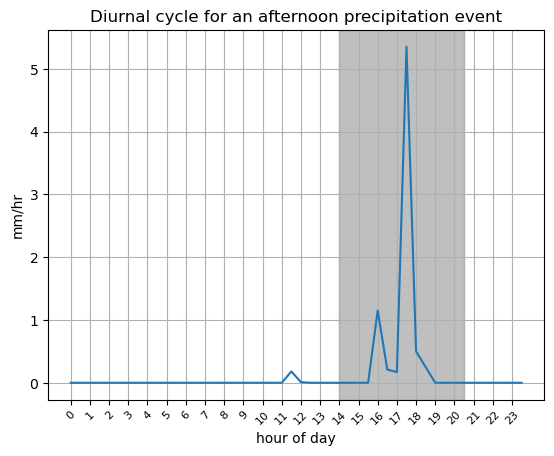

In [666]:
chosen_date = datetime.date(2005, 5, 1)

ape_info = apes_dict[chosen_date]

all_p = []

specific_lat = 48

specific_lon = 9

print(specific_lon, specific_lat)

for hour in range(24):  # for each hour (0 to 23)
    
    for minute in [0, 30]:  # for 0 and 30 minute segments
        
        # Dynamically create current_time based on chosen_date, hour, and minute
        current_time = datetime.datetime.combine(chosen_date, datetime.time(hour, minute))
        
        # Fetch data for the current time
        p = results_dict[current_time].data[specific_lon, specific_lat]
        
        all_p.append(p)
        
        
# Time list (hours)
time_list = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]

# Create plot
plt.plot(all_p)

plt.axvspan(28, 41, color='gray', alpha=0.5)

# Title
plt.title("Diurnal cycle for an afternoon precipitation event")

# Set x-ticks: Map the positions for ticks (every 2 elements) to the `time_list` values
plt.xticks(ticks=range(0, len(all_p), 2), labels=time_list, rotation=45, size=8)

# Y-axis label
plt.ylabel("mm/hr")

plt.xlabel("hour of day")

# Show the plot
plt.grid()
plt.show()

## investigating a single day

mm/hr at APE point: 0.0


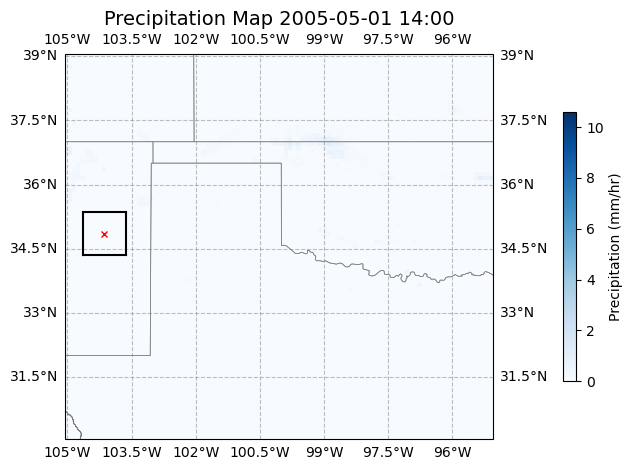

mm/hr at APE point: 0.0


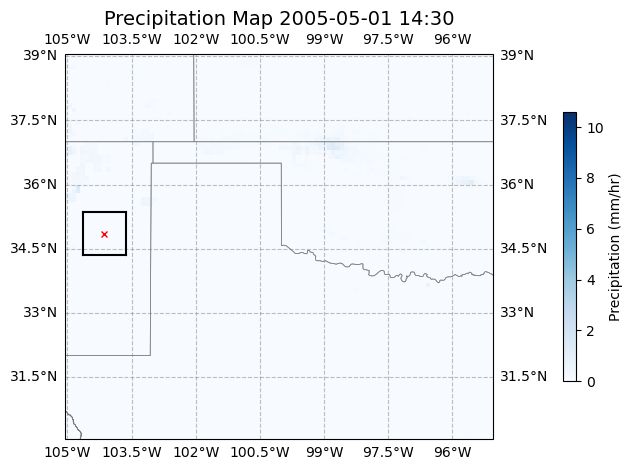

mm/hr at APE point: 0.0


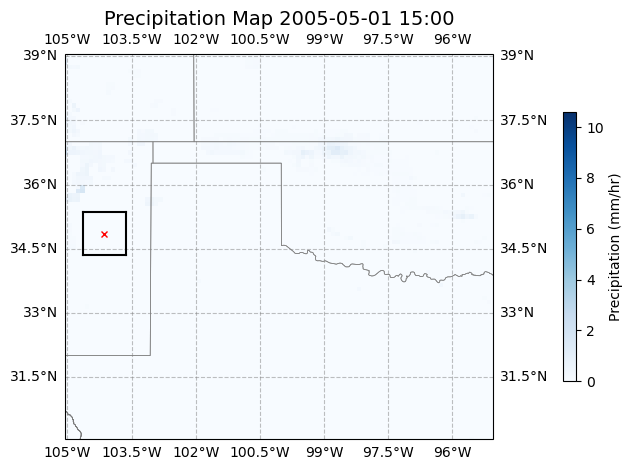

mm/hr at APE point: 0.0


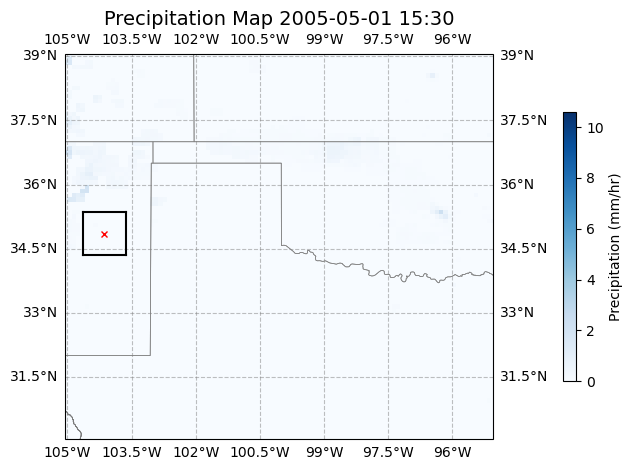

mm/hr at APE point: 1.15


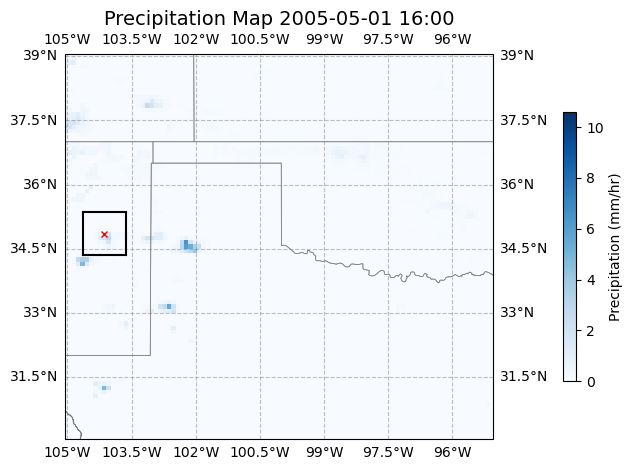

mm/hr at APE point: 0.21


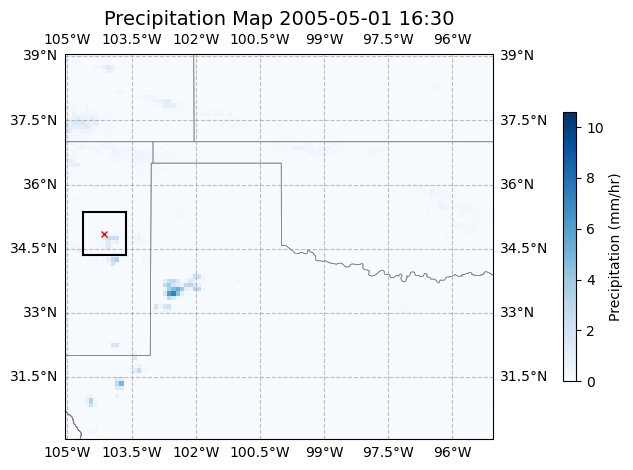

mm/hr at APE point: 0.17


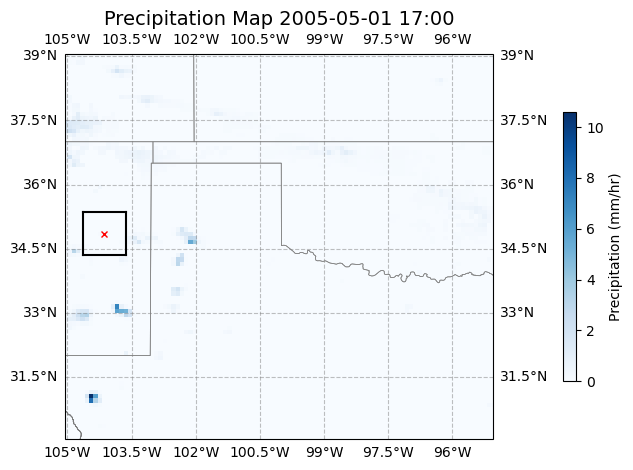

mm/hr at APE point: 5.35


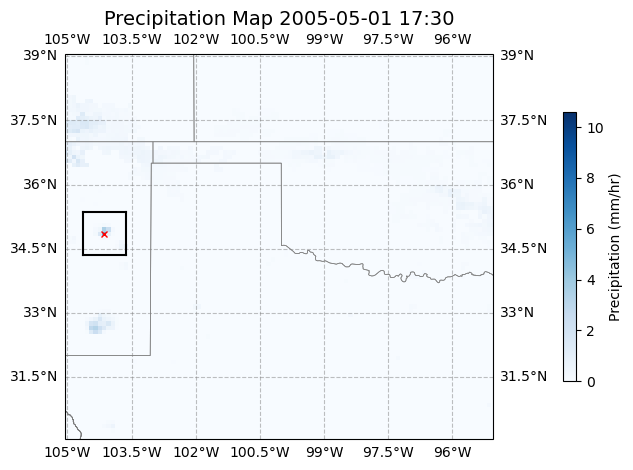

mm/hr at APE point: 0.5


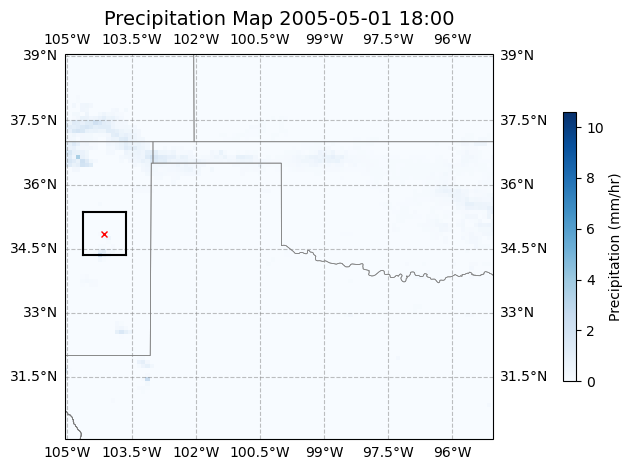

mm/hr at APE point: 0.25


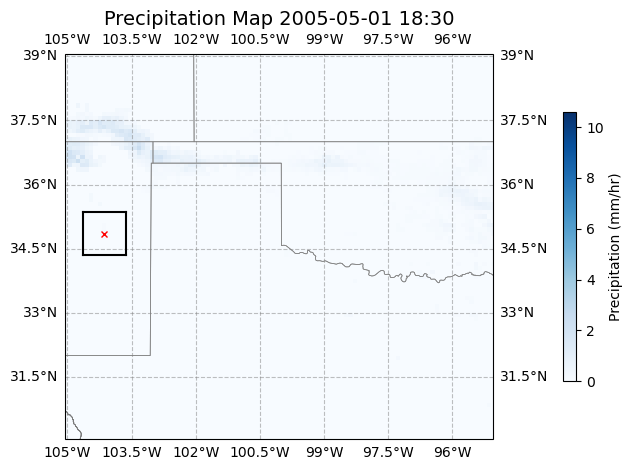

mm/hr at APE point: 0.0


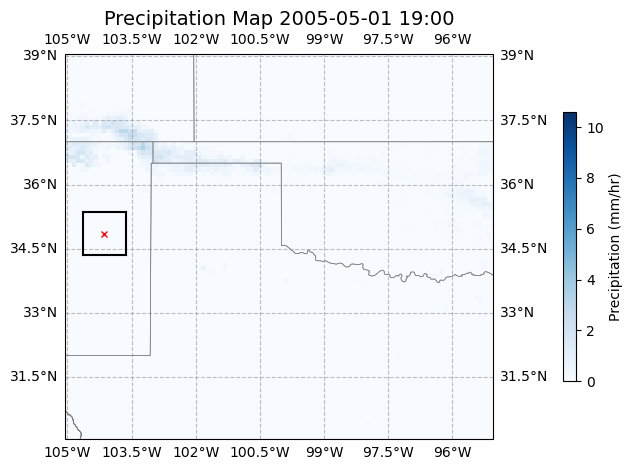

mm/hr at APE point: 0.0


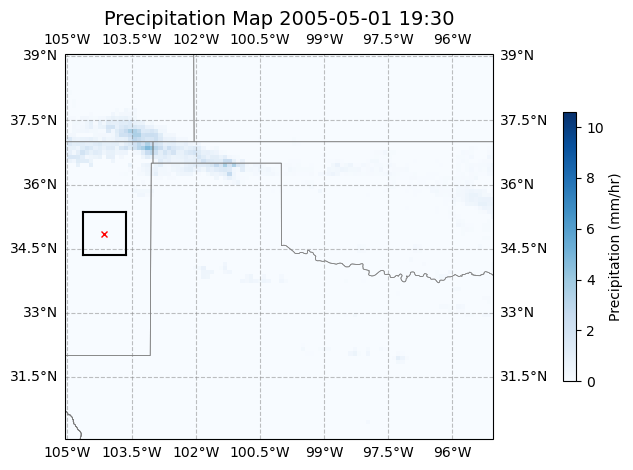

mm/hr at APE point: 0.0


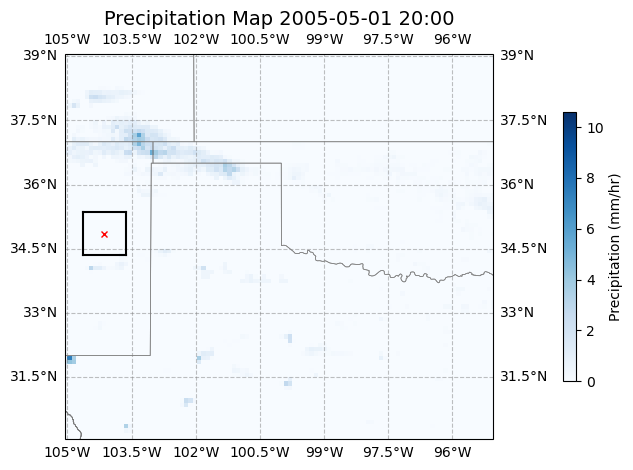

mm/hr at APE point: 0.0


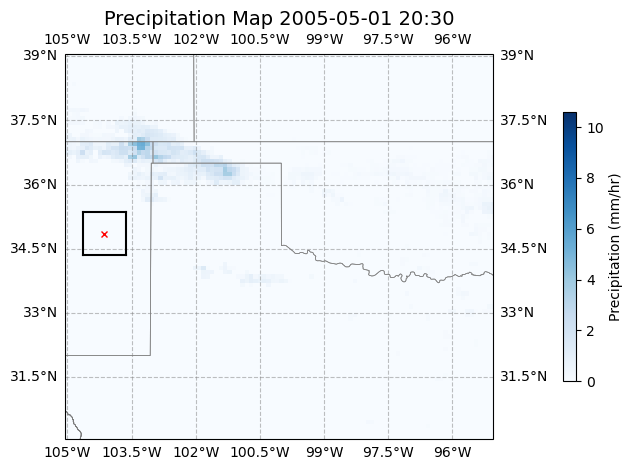

In [667]:
# Define the box size around the red "X" (adjust the size as needed)
box_size = 1  # Size of the box in degrees (you can adjust this value)

lat_to_plot = lats[specific_lat]
lon_to_plot = lons[specific_lon]

# Calculate the corners of the box (lat, lon)
lat_min = lat_to_plot - box_size / 2
lat_max = lat_to_plot + box_size / 2
lon_min = lon_to_plot - box_size / 2
lon_max = lon_to_plot + box_size / 2

# Step 1: Find the global maximum value for the afternoon hours (14:00 to 20:30)
global_max_value = None
for hour in range(14, 21):  # for each hour (14 to 20)
    for minute in [0, 30]:  # for 0 and 30 minute segments
        # Create datetime object for the specific time
        current_time = datetime.datetime(2005, 5, 1, hour, minute)  # Example date, adjust as necessary
        
        # Extract the data from the results_dict based on the datetime
        if current_time in results_dict:
            test_array = results_dict[current_time].data

            # Find the maximum value for the current time period (afternoon hours)
            if global_max_value is None:
                global_max_value = np.nanmax(test_array)  # Initialize with first value
            else:
                global_max_value = max(global_max_value, np.nanmax(test_array))

# Step 2: Now loop through the data and plot with the consistent colorbar range
for hour in range(14, 21):  # for each hour (14 to 20)
    for minute in [0, 30]:  # for 0 and 30 minute segments
        # Create datetime object for the specific time
        current_time = datetime.datetime(2005, 5, 1, hour, minute)  # Example date, adjust as necessary
        
        # Extract the data from the results_dict based on the datetime
        if current_time in results_dict:
            test_array = results_dict[current_time].data

            # Create a meshgrid for the latitudes and longitudes
            lon_grid, lat_grid = np.meshgrid(lons, lats)

            # Create the plot
            fig, ax = plt.subplots(figsize=(9, 5), subplot_kw={'projection': ccrs.PlateCarree()})

            # Plot the precipitation data
            precip_plot = ax.pcolormesh(lon_grid, lat_grid, test_array.T, cmap='Blues', 
                                        vmin=0, vmax=global_max_value, transform=ccrs.PlateCarree())

            # Add features to the map
            ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
            ax.add_feature(cfeature.BORDERS, linewidth=0.5)
            ax.add_feature(cfeature.STATES, linewidth=0.5, edgecolor='gray')

            ax.gridlines(draw_labels=True, linestyle="--", color="gray", alpha=0.5)

            # Add colorbar with the same scale across all plots
            cbar = plt.colorbar(precip_plot, ax=ax, orientation='vertical', shrink=0.7, pad=0.1)
            cbar.set_label('Precipitation (mm/hr)')

            # Set map extent (optional)
            ax.set_extent([lon_grid.min(), lon_grid.max(), lat_grid.min(), lat_grid.max()], crs=ccrs.PlateCarree())

            # Add title
            ax.set_title(f"Precipitation Map {current_time.strftime('%Y-%m-%d %H:%M')}", fontsize=14)

            # Add the red "X" at the specific latitude and longitude
            ax.plot(lon_to_plot, lat_to_plot, marker='x', color='red', markersize=5, transform=ccrs.PlateCarree())
            
            precip_at_red_x = test_array[specific_lon, specific_lat]
                         
            print("mm/hr at APE point:", precip_at_red_x)
            # Add the box around the red "X"
            ax.plot([lon_min, lon_max], [lat_min, lat_min], color='black', linestyle='-', transform=ccrs.PlateCarree())  # Bottom side
            ax.plot([lon_min, lon_max], [lat_max, lat_max], color='black', linestyle='-', transform=ccrs.PlateCarree())  # Top side
            ax.plot([lon_min, lon_min], [lat_min, lat_max], color='black', linestyle='-', transform=ccrs.PlateCarree())  # Left side
            ax.plot([lon_max, lon_max], [lat_min, lat_max], color='black', linestyle='-', transform=ccrs.PlateCarree())  # Right side

            # Show the plot
            plt.show()
        else:
            print(f"Data for {current_time} not available.")


In [411]:
# dates = []

# afternoon_precips = []

# # Iterate through the dictionary
# for date, value in apes_dict.items():
    
#     if value['APE'] == True:

#         # Extract the afternoon precipitation for each date    
#         afternoon_precip = value['precip_info'][0]['afternoon_precip']

#         # Append to the lists
#         dates.append(date)
#         afternoon_precips.append(afternoon_precip)
    
#     else: 

#         continue

# # Create the DataFrame
# ape_df = pd.DataFrame({
#     'date': dates,
#     'aft_precip_mm': afternoon_precips
# })

## exclusion of tropical cyclones

In [ ]:
# hurdat = tracks.TrackDataset(basin='north_atlantic', source='hurdat', include_btk=False)

# # Define latitude and longitude range for filtering
# lat_min, lat_max = 30, 39

# lon_min, lon_max = -105, -95

# tc_list = []

# tc_time_list = []

# for id_ in hurdat.keys:
    
#     #excluding dates before 2000
    
#     if int(id_[-4:]) < 2000:
        
#         continue
    
#     lat = np.array(hurdat.data[id_]['lat'][:])
    
#     lon = np.array(hurdat.data[id_]['lon'][:])
    
#     # Check if any point in the track falls within the desired latitude/longitude range
#     for j in range(len(lat)):
        
#         if lat_min <= lat[j] <= lat_max and lon_min <= lon[j] <= lon_max:
            
#             # If the TC is within the domain, add the time to tc_time_list
#             tc_time_list = np.append(tc_time_list, np.array(hurdat.data[id_]['time'])[j])
            
#             tc_list.append(id_)
            
#             break  # Once a TC track is found within the domain, no need to check further

# # Convert times to datetime format
# tc_time = []

# for tt in tc_time_list:
    
#     tc_time.append(np.datetime64(tt))

# # Adjust for time zone (subtract 6 hours)
# ok_tc_time = []

# for i in tc_time:
    
#     ok_tc_time.append(i - pd.to_timedelta('6 hours'))

# # Convert to date format and store in tc_dates
# tc_dates = []

# for dt in ok_tc_time:
    
#     d = dt.date()
    
#     tc_dates.append(d)

# # Get unique dates
# tc_dates = list(set(tc_dates))

In [680]:
# Loop through the apes_dict to extract the information
data = []

for date, info in apes_dict.items():
    
    if info['APE']:
        
        for precip_info in info['precip_info']:
            
            lat_idx = precip_info['lat_idx']
            
            lon_idx = precip_info['lon_idx']
            
            aft_precip = precip_info['afternoon_precip']
            
            # Convert indices to actual latitude and longitude values
            latitude = lats[lat_idx]
            
            longitude = lons[lon_idx]
            
            # Append the data as a dictionary
            data.append({
                'date': date,
                'latitude': latitude,
                'longitude': longitude,
                'total_afternoon_precip': aft_precip
            })

# Create a DataFrame from the list of dictionaries
ape_df = pd.DataFrame(data)

In [682]:
ape_df.sort_values(by='total_afternoon_precip', ascending=False)

,date,latitude,longitude,total_afternoon_precip
82,2005-08-23,32.95,-97.070202,16.184999
107,2005-09-06,37.75,-98.585354,11.440000
81,2005-08-22,36.05,-99.090404,10.115001
63,2005-08-03,30.85,-103.534848,9.925000
46,2005-07-14,33.65,-100.100505,9.780000
85,2005-08-25,38.15,-98.787374,9.264999
70,2005-08-08,34.75,-104.443939,9.164999
36,2005-07-03,31.75,-101.413636,9.125000
79,2005-08-22,35.95,-99.393434,8.764999
104,2005-09-05,34.95,-101.211616,8.685000


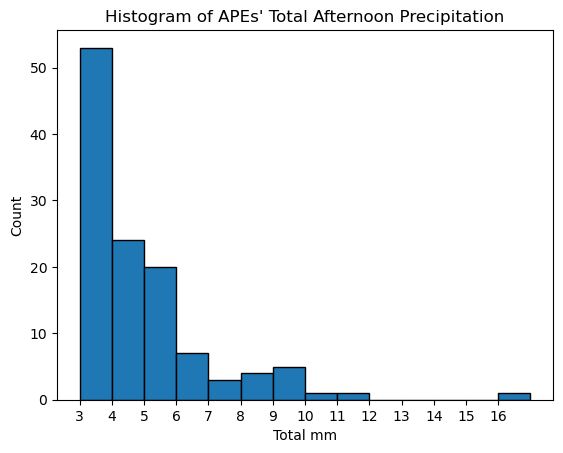

In [683]:
# Determine the range of your data
x_min = int(ape_df['total_afternoon_precip'].min())
x_max = int(ape_df['total_afternoon_precip'].max())

# Use bins that align with integers
bins = np.arange(x_min, x_max + 2)  # +2 to include the last integer as a separate bin

# Plot the histogram
plt.hist(ape_df['total_afternoon_precip'], bins=bins, edgecolor='black')
plt.ylabel("Count")
plt.title("Histogram of APEs' Total Afternoon Precipitation")
plt.xlabel("Total mm")

# Set x-ticks at every integer
plt.xticks(np.arange(x_min, x_max + 1, 1))

plt.show()


In [659]:
with open('ape_df.pkl', 'wb') as f:
    
    pickle.dump(ape_df, f)

In [684]:
counts = ape_df['date'].value_counts()

np.mean(counts)

1.5657894736842106

In [664]:
ape_df.head()

,date,latitude,longitude,total_afternoon_precip
0,2005-05-01,30.95,-104.443939,5.684999
1,2005-05-01,34.85,-104.140909,3.815000
2,2005-05-01,33.15,-103.837879,3.605000
3,2005-05-05,30.95,-103.029798,3.420000
4,2005-05-05,36.65,-100.706566,3.425000
